In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import scale
import seaborn as sns
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

In [5]:
forest = pd.read_csv('forestfires.csv')
forest

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


C:\Users\SATHISH KUMAR K\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='size_category', ylabel='count'>

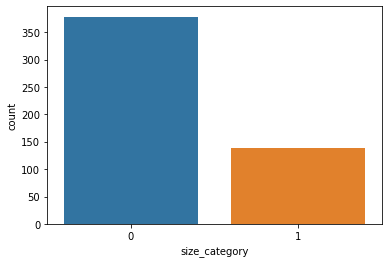

In [6]:
data = forest.drop(columns = ['month', 'day'])
data['size_category'] = data['size_category'].map({'small': 0, 'large': 1})
sns.countplot(data['size_category'])

In [7]:
y = data.iloc[:,-1]
X = data.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [8]:
resample = SMOTE()
X_train_res, y_train_res = resample.fit_resample(X_train, y_train)
X_train_scaled = scale(X_train_res)
X_test_scaled = scale(X_test)

In [9]:
input_size = len(X.columns)
output_size = 2

In [10]:
def optimal_model(activation_function, hidden_layer_size, optimizer):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hidden_layer_size, input_dim = input_size,
                                   activation = activation_function))
    model.add(tf.keras.layers.Dense(hidden_layer_size,
                                   activation = activation_function))
    model.add(tf.keras.layers.Dense(hidden_layer_size,
                                   activation = activation_function))
    model.add(tf.keras.layers.Dense(output_size, activation = 'softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer,
                 metrics = ['accuracy'])
    return model

In [11]:
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = optimal_model, verbose = 0)
activation_function = ['relu', 'sigmoid']
hidden_layer_size = [10, 30, 50]
optimizer = ['adam', 'sgd']
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [12]:
params_grid = dict(activation_function = activation_function,
                  hidden_layer_size = hidden_layer_size, optimizer = optimizer, epochs = [50],
                  validation_split = [0.1])


In [13]:
grid = GridSearchCV(estimator = model, param_grid = params_grid, cv = 5, verbose = 2)
results = grid.fit(X_train_scaled, y_train_res)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=adam, validation_split=0.1; total time=   4.4s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=adam, validation_split=0.1; total time=   3.3s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=adam, validation_split=0.1; total time=   3.2s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=adam, validation_split=0.1; total time=   3.6s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=adam, validation_split=0.1; total time=   3.5s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=sgd, validation_split=0.1; total time=   3.2s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10, optimizer=sgd, validation_split=0.1; total time=   3.5s
[CV] END activation_function=relu, epochs=50, hidden_layer_size=10

In [14]:
results.best_score_, results.best_params_

(0.9355234265327453,
 {'activation_function': 'sigmoid',
  'epochs': 50,
  'hidden_layer_size': 50,
  'optimizer': 'adam',
  'validation_split': 0.1})

In [15]:
hidden_layer_size = 30
model = tf.keras.Sequential([
                                tf.keras.layers.Dense(hidden_layer_size, input_dim = input_size, activation = 'relu'),
                                tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),
                                tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'),     
                                tf.keras.layers.Dense(output_size, activation = 'softmax')
])

In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [17]:
num_epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping()
model.fit(X_train_scaled, y_train_res, callbacks = [early_stopping], validation_split = 0.1, epochs = num_epochs, verbose = 2)

Epoch 1/50
17/17 - 1s - loss: 0.6539 - accuracy: 0.6501 - val_loss: 0.6804 - val_accuracy: 0.6393


In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 9.7388 - accuracy: 0.2692


In [19]:
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 9.74. Test accuracy: 26.92%
